In [53]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
neues_verzeichnis = "C:\\Users\\Lucian\\Desktop\\WebMining_final"
os.chdir(neues_verzeichnis)

In [54]:
df = pd.read_csv("filtered_games.csv")
genres = pd.read_csv("steam_game_genres_normalized.csv")


In [55]:
genres_clean = genres.dropna(subset=['genres'])
valid_appids = genres_clean['appid'].unique()

df_clean = df[df['appid'].isin(valid_appids)]

# Anzahl der einzigartigen Spieler
player_count = df_clean['steam_64_id'].nunique()

# Anzahl der einzigartigen Spiele
games_count = df_clean['appid'].nunique()

print("Anzahl der einzigartigen Spieler: ", player_count)
print("Anzahl der einzigartigen Spiele: ", games_count) 

Anzahl der einzigartigen Spieler:  41623
Anzahl der einzigartigen Spiele:  15018


In [56]:
# Schritt 1: Berechne die Gesamtspielzeit für jedes Genre
df_genre_playtime = df_clean.merge(genres_clean, on="appid")
df_genre_playtime["genres"] = df_genre_playtime["genres"].str.split(",")  # Split Genres
df_genre_playtime = df_genre_playtime.explode("genres")  # Explode Genres
df_genre_playtime["genres"] = df_genre_playtime["genres"].str.strip()  # Strip Whitespaces

# Schritt 2: Berechne die Gesamtspielzeit für jedes Genre
genre_total_playtime = df_genre_playtime.groupby("genres")["playtime_forever"].sum()

# Schritt 3: Berechne die Gesamtspielzeit aller Spieler
total_playtime = df_clean["playtime_forever"].sum()

# Schritt 4: Berechne den neuen IDF-Wert für jedes Genre
genre_idf = np.log(total_playtime / genre_total_playtime)
genre_idf.sort_values(ascending=False, inplace=True)

# Schritt 5: In DataFrame umwandeln & ausgeben
df_genre_idf = genre_idf.reset_index()
df_genre_idf.columns = ["Genre", "IDF_Playtime"]  # Spalten sinnvoll benennen
print(df_genre_idf.sort_values(by="IDF_Playtime", ascending=False))
print(df_genre_idf.shape)



               Genre  IDF_Playtime
0              Movie     13.450546
1      Adult Content     11.471561
2            Violent     10.354341
3             Racing      5.097642
4       Early Access      4.477259
5   Software & Tools      4.235007
6             Sports      4.055663
7             Casual      3.423947
8         Simulation      2.831690
9                MMO      2.451395
10             Indie      2.307354
11               RPG      2.285862
12         Adventure      1.812827
13          Strategy      0.537173
14      Free-to-Play      0.280589
15            Action      0.101687
(16, 2)


In [57]:
df_genre_idf.to_csv("genre_idf.csv", index=False)

In [58]:
# Spielzeit pro Genre für jeden Spieler berechnen
df_tf = df_genre_playtime.groupby(["steam_64_id", "genres"])["playtime_forever"].sum().reset_index()

# Gesamtspielzeit pro Spieler berechnen
total_playtime_per_player = df_clean.groupby("steam_64_id")["playtime_forever"].sum().reset_index()
total_playtime_per_player.rename(columns={"playtime_forever": "total_playtime"}, inplace=True)

# Mit der originalen TF-Tabelle zusammenführen
df_tf = df_tf.merge(total_playtime_per_player, on="steam_64_id")

# Relative TF berechnen (Spielzeit für ein Genre relativ zur gesamten Spielzeit des Spielers)
df_tf["TF_relative"] = df_tf["playtime_forever"] / df_tf["total_playtime"]

# Mit IDF-Werten verknüpfen
df_tf = df_tf.merge(df_genre_idf, left_on="genres", right_on="Genre", how="left")

# TF-IDF berechnen
df_tf["TF-IDF"] = df_tf["TF_relative"] * df_tf["IDF_Playtime"]

# Unnötige Spalten entfernen
df_tf.drop(columns=["playtime_forever", "total_playtime", "IDF_Playtime", "Genre"], inplace=True)

df_tf


,steam_64_id,genres,TF_relative,TF-IDF
0,76561197960359575,Action,0.669531,0.068083
1,76561197960359575,Adventure,0.391628,0.709955
2,76561197960359575,Casual,0.052998,0.181462
3,76561197960359575,Early Access,0.043563,0.195043
4,76561197960359575,Free-to-Play,0.214938,0.060309
...,...,...,...,...
378825,76561199806753268,Free-to-Play,1.000000,0.280589
378826,76561199806753268,Strategy,1.000000,0.537173
378827,76561199807600301,Action,1.000000,0.101687
378828,76561199807600301,Free-to-Play,1.000000,0.280589


In [59]:
# Spieler-Genre-Vektoren erstellen (Pivot-Tabelle)
df_player_tfidf = df_tf.pivot(index="steam_64_id", columns="genres", values="TF-IDF").fillna(0)

# Ergebnis anzeigen
print("TF-IDF Vektoren für Spieler-Genres erstellt")
print(df_player_tfidf)


TF-IDF Vektoren für Spieler-Genres erstellt
genres               Action  Adult Content  Adventure    Casual  Early Access  \
steam_64_id                                                                     
76561197960359575  0.068083            0.0   0.709955  0.181462      0.195043   
76561197960471729  0.091812            0.0   0.613282  0.210635      0.098759   
76561197960481035  0.080745            0.0   0.291181  0.027780      0.061056   
76561197960493780  0.042724            0.0   0.034725  0.309493      0.000000   
76561197960497152  0.079912            0.0   0.422005  0.276670      0.071546   
...                     ...            ...        ...       ...           ...   
76561199793735600  0.101687            0.0   0.000000  0.000000      0.000000   
76561199793735604  0.101687            0.0   0.000000  0.000000      0.000000   
76561199803373970  0.083221            0.0   0.258483  0.243961      0.000000   
76561199806753268  0.101687            0.0   0.000000  0.000000  

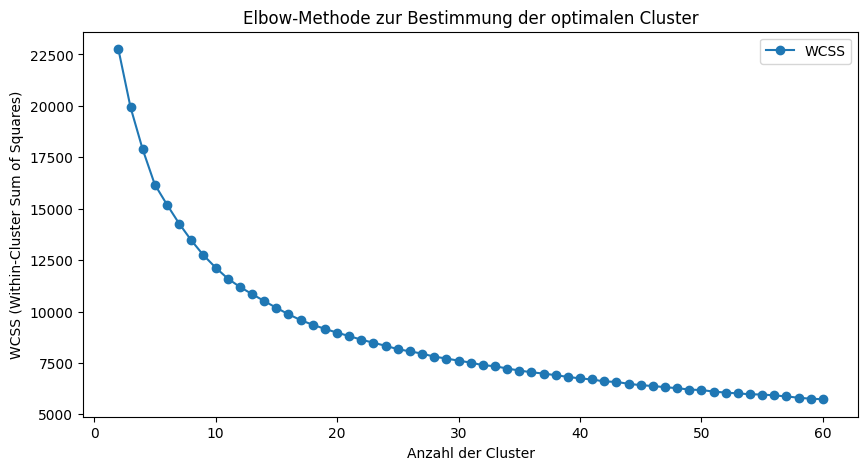

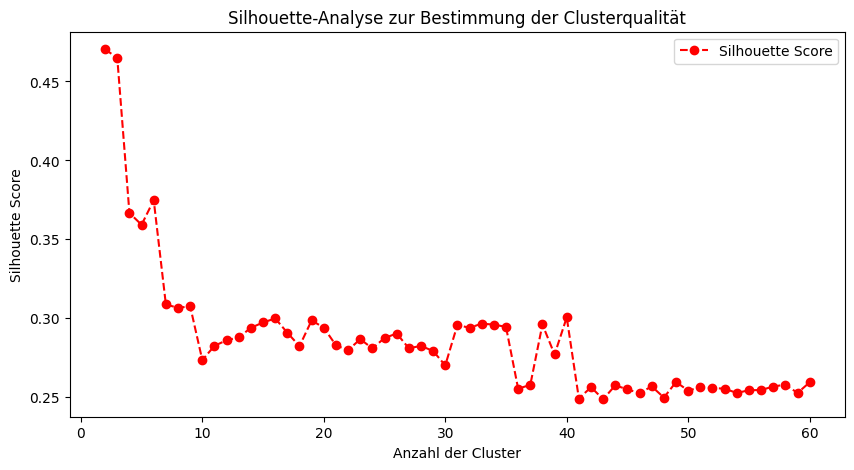

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

n_cluster = 61  # Maximale Anzahl an getesteten Clustern

wcss = []  # Liste für WCSS-Werte
silhouette_scores = []  # Liste für Silhouette-Scores
cluster_range = range(2, n_cluster)  # Cluster von 2 bis n_cluster testen

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_player_tfidf)
    
    wcss.append(kmeans.inertia_)  # WCSS speichern
    silhouette_avg = silhouette_score(df_player_tfidf, cluster_labels)  # Silhouette Score berechnen
    silhouette_scores.append(silhouette_avg)  # Silhouette Score speichern

# Plot für Elbow-Methode (WCSS)
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, wcss, marker='o', label="WCSS")
plt.xlabel("Anzahl der Cluster")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Cluster")
plt.legend()
plt.show()

# Plot für Silhouette-Score
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='r', label="Silhouette Score")
plt.xlabel("Anzahl der Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette-Analyse zur Bestimmung der Clusterqualität")
plt.legend()
plt.show()


In [37]:
print(wcss)
print(silhouette_scores)

[22754.85656428523, 19932.389787924556, 17886.32961029659, 16173.435155336516, 15199.42824418691, 14279.050026587249, 13463.676759259417, 12742.016491418965, 12139.891519300296, 11605.944738203474, 11198.705404202958, 10850.18109669826, 10513.906868041542, 10182.122532374415, 9868.816913078927, 9585.591792197021, 9355.95741313721, 9158.70294305845, 8974.023176455277, 8807.501034320172, 8631.046085508631, 8482.587447848182, 8334.247751087965, 8170.823489933672, 8063.402586080023, 7954.442506716069, 7806.6814614153145, 7716.514933679497, 7610.7554445715705, 7519.380679233158, 7391.849442673667, 7343.516645355962, 7229.89948267758, 7132.870886363256, 7047.534006082167, 6984.624207533528, 6905.531205574651, 6822.7316586904235, 6749.558194543109, 6697.270639501339, 6600.566474593346, 6580.560675129049, 6485.039904724087, 6421.5035524896075, 6378.635009946065, 6322.728080280303, 6274.92019520516, 6206.24528687979, 6182.724948220033, 6109.2566813025305, 6058.319700113343, 6021.143790858897, 5

Clusteranzahl: 3, Silhouette Score: 0.4648
Clusteranzahl: 4, Silhouette Score: 0.3667
Clusteranzahl: 5, Silhouette Score: 0.3592
Clusteranzahl: 6, Silhouette Score: 0.3748
Clusteranzahl: 7, Silhouette Score: 0.3089


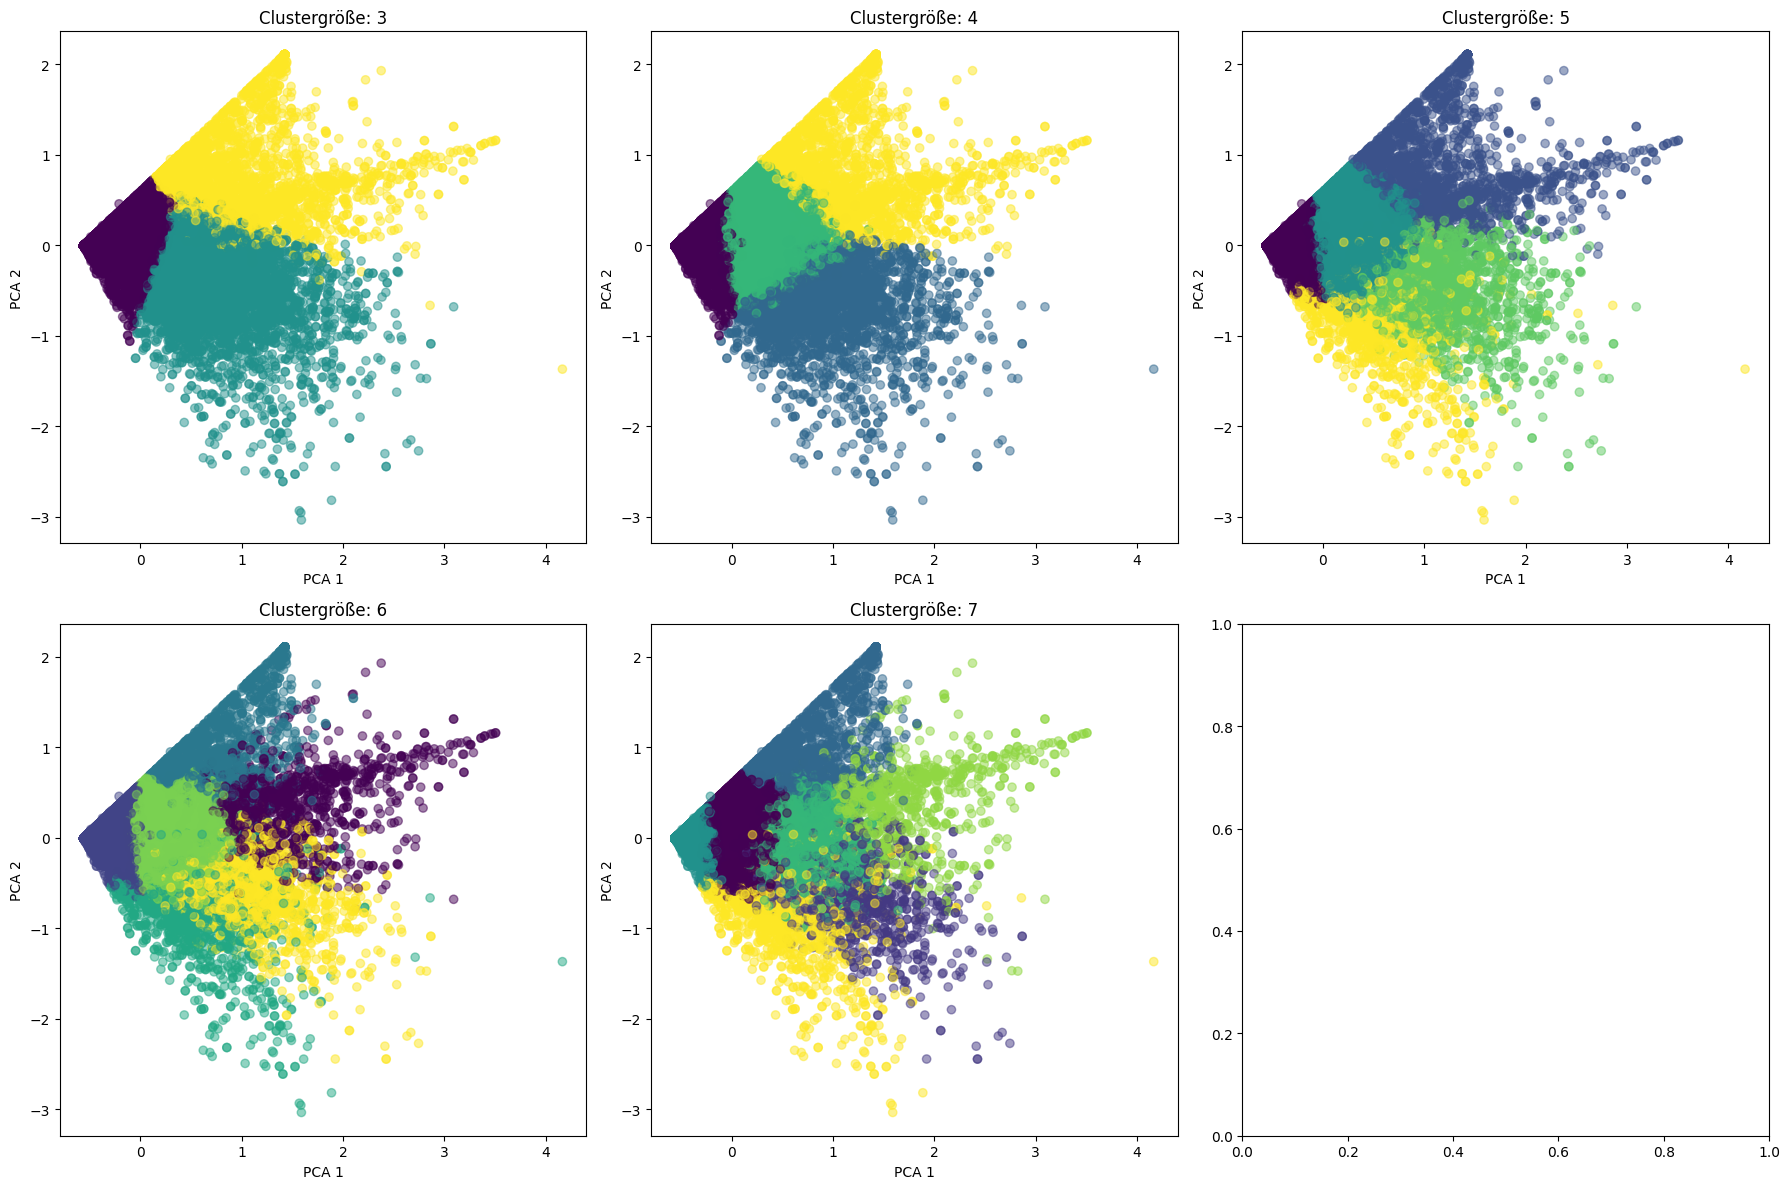

                                         F-Statistik  \
3  [12445.574480156965, 89.2842462780852, 29080.0...   
4  [11031.635336120034, 66.42384035329358, 26042....   
5  [8093.803825905445, 68.35934459230307, 22837.8...   
6  [6848.941831622816, 58.37720345859134, 17582.4...   
7  [6028.805327348703, 54.10063440410078, 17245.3...   

                                              p-Wert  
3  [0.0, 2.029036433137069e-39, 0.0, 0.0, 0.0, 0....  
4  [0.0, 7.670032641001418e-43, 0.0, 0.0, 0.0, 0....  
5  [0.0, 8.999178824393546e-58, 0.0, 0.0, 0.0, 0....  
6  [0.0, 9.153202678288441e-61, 0.0, 0.0, 0.0, 0....  
7  [0.0, 8.034115802980597e-67, 0.0, 0.0, 0.0, 0....  


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway

# Clustergrößen definieren
cluster_sizes = range(3, 8)

# Ergebnisse speichern
cluster_results = {}

# Daten vorbereiten
df_features = df_player_tfidf.copy()  # Feature-Daten für Clustering

for k in cluster_sizes:
    # K-Means Clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_features)

    # Clusterzentren speichern
    cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_features.columns)

    # Silhouette Score berechnen
    silhouette_avg = silhouette_score(df_features, cluster_labels)

    # Ergebnisse speichern
    cluster_results[k] = {
        "labels": cluster_labels,
        "centers": cluster_centers,
        "silhouette_score": silhouette_avg
    }

    print(f"Clusteranzahl: {k}, Silhouette Score: {silhouette_avg:.4f}")

# Clusterverteilung visualisieren (PCA-Reduktion)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, k in enumerate(cluster_sizes):
    # PCA-Reduktion auf 2D
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(df_features)
    
    # Scatterplot
    ax = axes[i]
    scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_results[k]["labels"], cmap="viridis", alpha=0.5)
    ax.set_title(f"Clustergröße: {k}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

# Varianzanalyse für Clustertrennung
anova_results = {}

for k in cluster_sizes:
    labels = cluster_results[k]["labels"]
    
    # Erstelle eine Liste mit Feature-Werten pro Cluster
    cluster_groups = [df_features.iloc[labels == c].values for c in range(k)]
    
    # F-Test durchführen
    f_stat, p_value = f_oneway(*cluster_groups)
    anova_results[k] = {"F-Statistik": f_stat, "p-Wert": p_value}

# Ergebnisse ausgeben
df_anova_results = pd.DataFrame(anova_results).T
print(df_anova_results)


In [62]:
# Extrahiere die Labels für Clustergröße 3
cluster_3_labels = cluster_results[3]["labels"]

# Erstelle einen DataFrame mit Spieler-IDs und zugewiesenen Clustern
df_cluster_3 = df_player_tfidf.copy()
df_cluster_3["Cluster"] = cluster_3_labels

print(df_cluster_3) 




genres               Action  Adult Content  Adventure    Casual  Early Access  \
steam_64_id                                                                     
76561197960359575  0.068083            0.0   0.709955  0.181462      0.195043   
76561197960471729  0.091812            0.0   0.613282  0.210635      0.098759   
76561197960481035  0.080745            0.0   0.291181  0.027780      0.061056   
76561197960493780  0.042724            0.0   0.034725  0.309493      0.000000   
76561197960497152  0.079912            0.0   0.422005  0.276670      0.071546   
...                     ...            ...        ...       ...           ...   
76561199793735600  0.101687            0.0   0.000000  0.000000      0.000000   
76561199793735604  0.101687            0.0   0.000000  0.000000      0.000000   
76561199803373970  0.083221            0.0   0.258483  0.243961      0.000000   
76561199806753268  0.101687            0.0   0.000000  0.000000      0.000000   
76561199807600301  0.101687 

In [63]:
df_cluster_3 = df_cluster_3.reset_index()
print(df_cluster_3)

genres        steam_64_id    Action  Adult Content  Adventure    Casual  \
0       76561197960359575  0.068083            0.0   0.709955  0.181462   
1       76561197960471729  0.091812            0.0   0.613282  0.210635   
2       76561197960481035  0.080745            0.0   0.291181  0.027780   
3       76561197960493780  0.042724            0.0   0.034725  0.309493   
4       76561197960497152  0.079912            0.0   0.422005  0.276670   
...                   ...       ...            ...        ...       ...   
41618   76561199793735600  0.101687            0.0   0.000000  0.000000   
41619   76561199793735604  0.101687            0.0   0.000000  0.000000   
41620   76561199803373970  0.083221            0.0   0.258483  0.243961   
41621   76561199806753268  0.101687            0.0   0.000000  0.000000   
41622   76561199807600301  0.101687            0.0   0.000000  0.000000   

genres  Early Access  Free-to-Play     Indie       MMO  Movie       RPG  \
0           0.195043    

In [64]:
cluster = df_cluster_3[["steam_64_id", "Cluster"]]

df_player_clustered = df_clean.copy()
df_player_clustered = df_player_clustered.merge(cluster, on="steam_64_id")
df_player_clustered

,steam_64_id,appid,name,playtime_forever,playtime_2weeks,has_community_visible_stats,Cluster
0,76561198144322955,570,Dota 2,1471505,3386,False,0
1,76561198090414113,570,Dota 2,1444943,5160,False,0
2,76561198071834270,570,Dota 2,1414116,3786,False,0
3,76561198141513114,730,Counter-Strike 2,1403698,0,True,0
4,76561198262602149,570,Dota 2,1390685,2638,False,0
...,...,...,...,...,...,...,...
1297155,76561198159357343,524220,NieR:Automata™,240,0,True,0
1297156,76561198251210208,641990,The Escapists 2,240,0,True,0
1297157,76561197982689005,266840,Age of Mythology: Extended Edition,240,0,True,0
1297158,76561198049905605,343860,Tacoma,240,0,True,1


In [65]:
df_player_clustered.to_csv("clustered_players.csv", index=False)

In [66]:
# Ausgabe der Cluster-Verteilung
print(df_cluster_3["Cluster"].value_counts())

Cluster
0    29647
1     8866
2     3110
Name: count, dtype: int64


In [67]:
cluster_3_centers = cluster_results[3]["centers"]
print(cluster_3_centers.T)  # Transponieren für bessere Übersicht


                         0         1         2
genres                                        
Action            0.097426  0.076500  0.093913
Adult Content     0.000032  0.000393  0.000025
Adventure         0.139089  0.555503  1.009059
Casual            0.047799  0.312753  0.124792
Early Access      0.019727  0.137735  0.077556
Free-to-Play      0.248813  0.121258  0.181475
Indie             0.078266  0.625724  0.451902
MMO               0.099884  0.235476  1.160243
Movie             0.000006  0.000030  0.000003
RPG               0.082134  0.515792  0.517147
Racing            0.014939  0.088913  0.030188
Simulation        0.062396  0.485716  0.168292
Software & Tools  0.026128  0.140843  0.066552
Sports            0.029134  0.203374  0.041218
Strategy          0.354800  0.155726  0.115483
Violent           0.000148  0.000905  0.000167


In [ ]:
# Berechnung der Durchschnittswerte pro Cluster
cluster_genre_means = df_cluster_3.groupby("Cluster").mean()

# Sortierung der stärksten Genre-Präferenzen pro Cluster
for cluster in range(3):
    print(f"\nCluster {cluster} - Top 5 Genre-Präferenzen:")
    print(cluster_genre_means.loc[cluster].sort_values(ascending=False).head(5))


In [69]:
# Berechnung der Durchschnittswerte pro Cluster (ohne steam_64_id)
cluster_genre_means = df_cluster_3.drop(columns=["steam_64_id"]).groupby("Cluster").mean()

# Sortierung der stärksten Genre-Präferenzen pro Cluster
for cluster in range(3):
    print(f"\nCluster {cluster} - Top 5 Genre-Präferenzen:")
    print(cluster_genre_means.loc[cluster].sort_values(ascending=False).head(5))



Cluster 0 - Top 5 Genre-Präferenzen:
genres
Strategy        0.354741
Free-to-Play    0.248795
Adventure       0.139181
MMO             0.099889
Action          0.097423
Name: 0, dtype: float64

Cluster 1 - Top 5 Genre-Präferenzen:
genres
Indie         0.626079
Adventure     0.555569
RPG           0.515941
Simulation    0.485930
Casual        0.312978
Name: 1, dtype: float64

Cluster 2 - Top 5 Genre-Präferenzen:
genres
MMO             1.160243
Adventure       1.009059
RPG             0.517147
Indie           0.451902
Free-to-Play    0.181475
Name: 2, dtype: float64


In [70]:
df_cluster_3.to_csv("final_cluster.csv", index=False)
